# Settings

In [1]:
is_plot = True
is_export = True

landmarks_path = '/Users/knpob/Territory/2-Kolmo/4-Dataset/20230715-DynaBreastLite/landmark/landmark.pkl'
meshes_path = '/Users/knpob/Territory/2-Kolmo/4-Dataset/20230715-DynaBreastLite/mesh/'

start=0
stride = 12
end=120

export_folder = "../output/dataset/"

# Data loading

In [2]:
from mesh4d import obj3d
from mesh4d.analyse import crave

mesh_ls, texture_ls = obj3d.load_mesh_series(
    folder=meshes_path,
    start=start,
    stride=stride,
    end=end,
)

mesh_ls = [crave.fix_pvmesh_disconnect(mesh) for mesh in mesh_ls]

[====================] 100.0% loading: /Users/knpob/Territory/2-Kolmo/4-Dataset/20230715-DynaBreastLite/mesh/speed_6km_h_26_marker_set_.000121.obj


In [3]:
import numpy as np

def parse_vertex_color(mesh, texture) -> tuple:
    texture_img = np.array(texture.to_array())
    u, v = mesh.active_t_coords.T
    v_mapped = np.round((1 - v) * (texture_img.shape[0] - 1)).astype(int)
    u_mapped = np.round(u * (texture_img.shape[1] - 1)).astype(int)
    
    color_ls = texture_img[v_mapped, u_mapped]
    vertex_ls = np.array(mesh.points)
        
    return color_ls, vertex_ls

In [4]:
color_ls, vertex_ls = parse_vertex_color(mesh_ls[0], texture_ls[0])
color_ls, vertex_ls

(array([[154, 126, 114],
        [145, 117, 106],
        [151, 121, 111],
        ...,
        [ 88, 101, 117],
        [ 16,  17,  21],
        [ 11,  10,  15]], dtype=uint8),
 array([[-2.3071396e+02,  5.0928302e+02,  1.2648398e+02],
        [-2.3360876e+02,  5.0864197e+02,  1.2354577e+02],
        [-2.3355063e+02,  5.0495010e+02,  1.2582991e+02],
        ...,
        [-1.3025800e+02,  4.8718726e+02,  1.1515228e+02],
        [-1.6729851e+02,  2.0215393e+02, -1.0249020e+00],
        [-9.4630798e+01,  1.0942227e+03,  8.9963135e+01]], dtype=float32))

In [5]:
from scipy.spatial import KDTree

tree = KDTree(vertex_ls)

# Marker extraction

## Gray scale threshold

In [29]:
ds, idx = tree.query(vertex_ls, 10)
respond = np.sum(color_ls * [0.299, 0.587, 0.114], axis=1)
gray_ls = respond

'std 67.22712393647613 mean 92.53446643917805 min 0.929 max 255.0'

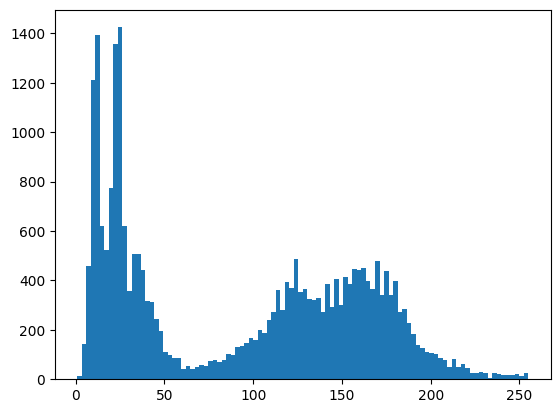

In [30]:
import matplotlib.pyplot as plt

mean = np.mean(respond)
std = np.std(respond)
plt.hist(gray_ls, bins=100)
f"std {np.std(gray_ls)} mean {np.mean(gray_ls)} min {np.min(gray_ls)} max {np.max(gray_ls)}"

In [31]:
mesh_ls[0].plot(scalars=-respond, cmap='cool')

Widget(value="<iframe src='http://localhost:56772/index.html?ui=P_0x7f79f49f9670_9&reconnect=auto' style='widt…

In [32]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[gray_ls < 100])
scene.add_mesh(cloud, point_size=2, color='goldenrod')
scene.add_mesh(mesh_ls[0], scalars=gray_ls, cmap='gray')
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:56772/index.html?ui=P_0x7f79dd43a7f0_10&reconnect=auto' style='wid…

## Local gray scale difference

In [33]:
ds, idx = tree.query(vertex_ls, 10)
respond = np.max(np.abs(gray_ls[idx]  - np.expand_dims(gray_ls, axis=-1)), axis=1)

'std 33.95282967982775 mean 22.14072165141743 min 0.0 max 241.423'

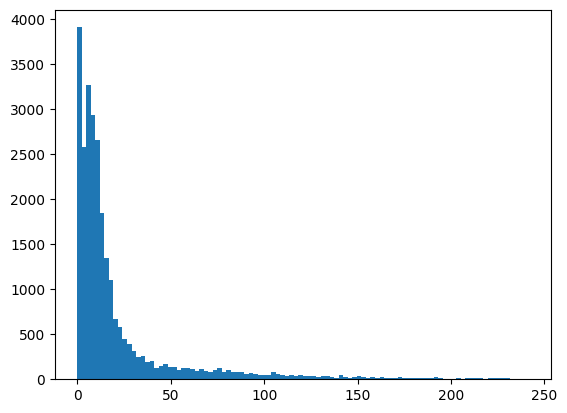

In [34]:
import matplotlib.pyplot as plt

mean = np.mean(respond)
std = np.std(respond)
plt.hist(respond, bins=100)
f"std {np.std(respond)} mean {np.mean(respond)} min {np.min(respond)} max {np.max(respond)}"

In [35]:
mesh_ls[0].plot(scalars=respond, cmap='cool')

Widget(value="<iframe src='http://localhost:56772/index.html?ui=P_0x7f79d3e4a310_11&reconnect=auto' style='wid…

In [36]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[respond > mean + 2 * std])
scene.add_mesh(cloud, point_size=2, color='goldenrod')
scene.add_mesh(mesh_ls[0], scalars=gray_ls, cmap='gray')
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:56772/index.html?ui=P_0x7f79de05ad00_12&reconnect=auto' style='wid…

## Local gray scale gradients

In [37]:
ds, idx = tree.query(vertex_ls, 100)
respond = np.max(np.abs(gray_ls[idx] - np.expand_dims(gray_ls, -1)) / (ds + 1e-5), axis=1)

'std 4.0321776426781115 mean 3.1184009700957027 min 0.04279150596163643 max 37.232114767483246'

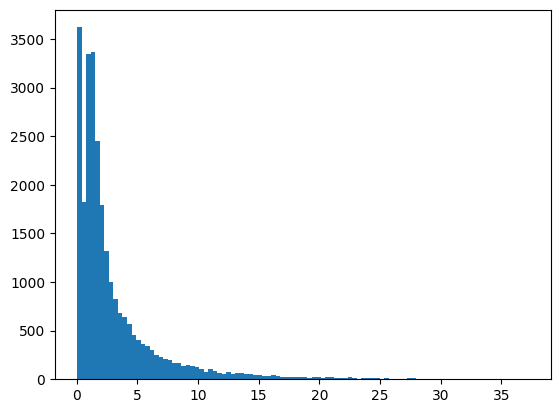

In [38]:
plt.hist(respond, bins=100)
mean = np.mean(respond)
std = np.std(respond)
f"std {np.std(respond)} mean {np.mean(respond)} min {np.min(respond)} max {np.max(respond)}"

In [39]:
mesh_ls[0].plot(scalars=respond, cmap='cool')

Widget(value="<iframe src='http://localhost:56772/index.html?ui=P_0x7f79de05a1f0_13&reconnect=auto' style='wid…

In [40]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[respond > mean + 2 * std])
scene.add_mesh(cloud, point_size=2, color='goldenrod')
scene.add_mesh(mesh_ls[0], scalars=gray_ls, cmap='gray')
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:56772/index.html?ui=P_0x7f79e12f78e0_14&reconnect=auto' style='wid…

# Batch validation

In [41]:
def extract(mesh, texture, pnum=100, range=2):
    color_ls, vertex_ls = parse_vertex_color(mesh, texture)
    gray_ls = np.sum(color_ls * [0.299, 0.587, 0.114], axis=1)
    
    tree = KDTree(vertex_ls)
    ds, idx = tree.query(vertex_ls, pnum)
    
    respond = np.max(np.abs(gray_ls[idx] - np.expand_dims(gray_ls, -1)) / (ds + 1e-5), axis=1)
    mean = np.mean(respond)
    std = np.std(respond)
    marker_vertex_ls = vertex_ls[respond > mean + range * std]
    # need to address empty issue

    return gray_ls, marker_vertex_ls

In [42]:
import os
from mesh4d import utils

scene.open_movie(os.path.join('output', 'marker.mp4'), framerate=round(120 / stride))
plot_num = len(mesh_ls)

for idx in range(len(mesh_ls)):
    scene.clear()
    
    gray_ls, marker_vertex_ls = extract(mesh_ls[idx], texture_ls[idx])
    cloud = pv.PolyData(marker_vertex_ls)
    scene.add_mesh(cloud, point_size=2, color='goldenrod')
    scene.add_mesh(mesh_ls[idx], scalars=gray_ls, cmap='gray')

    scene.camera_position = 'xy'
    scene.write_frame()

    percent = (idx + 1) / plot_num
    utils.progress_bar(percent, back_str=" exported the {}-th frame".format(idx))

scene.close()

[=                   ] 9.1% exported the 0-th frame

[swscaler @ 0x7fcf40048000] Warning: data is not aligned! This can lead to a speed loss


[====================] 100.0% exported the 10-th frame
